In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os,sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from skimage import util 
from skimage.transform import resize
from scipy.misc import imresize
from skimage.io import imread
import warnings
from numpy import inf

from scipy.stats import kurtosis,skew

plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")
import gc
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation
%load_ext jupyternotify

from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature

# Def: Read STL 10 images
def read_STL10_data():
    # read all of the data (STL 10) https://github.com/mttk/STL10
    def read_all_images(path_to_data):
        """
        :param path_to_data: the file containing the binary images from the STL-10 dataset
        :return: an array containing all the images
        """

        with open(path_to_data, 'rb') as f:
            # read whole file in uint8 chunks
            everything = np.fromfile(f, dtype=np.uint8)

            # We force the data into 3x96x96 chunks, since the
            # images are stored in "column-major order", meaning
            # that "the first 96*96 values are the red channel,
            # the next 96*96 are green, and the last are blue."
            # The -1 is since the size of the pictures depends
            # on the input file, and this way numpy determines
            # the size on its own.

            images = np.reshape(everything, (-1, 3, 96, 96))

            # Now transpose the images into a standard image format
            # readable by, for example, matplotlib.imshow
            # You might want to comment this line or reverse the shuffle
            # if you will use a learning algorithm like CNN, since they like
            # their channels separated.
            images = np.transpose(images, (0, 3, 2, 1))
            return images
    def read_labels(path_to_labels):
        """
        :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
        :return: an array containing the labels
        """
        with open(path_to_labels, 'rb') as f:
            labels = np.fromfile(f, dtype=np.uint8)
            return labels
    def show_images(data,row=1,col=1):
        fig=plt.figure(figsize=(10,10))
        columns = col; rows = row
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(data[i-1])
        plt.show()

    train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
    train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
    test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
    test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

    label_encoder= OneHotEncoder(sparse=False,categories='auto')
    train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
    test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

    print(train_images.shape,train_images.max(),train_images.min())
    print(train_labels.shape,train_labels.max(),train_labels.min())
    print(test_images.shape,test_images.max(),test_images.min())
    print(test_labels.shape,test_labels.max(),test_labels.min())
    return train_images,train_labels,test_images,test_labels
# Def: Read CIFAR 10 images
def read_CIFAR10_data():
    # ====== miscellaneous =====
    # code from: https://github.com/tensorflow/tensorflow/issues/8246
    def tf_repeat(tensor, repeats):
        """
        Args:

        input: A Tensor. 1-D or higher.
        repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input

        Returns:

        A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
        """
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
        repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
        return repeated_tesnor
    def unpickle(file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    # ====== miscellaneous =====

    # data
    PathDicom = "../../Dataset/cifar-10-batches-py/"
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if not ".html" in filename.lower() and not  ".meta" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))

    # Read the data traind and Test
    batch0 = unpickle(lstFilesDCM[0])
    batch1 = unpickle(lstFilesDCM[1])
    batch2 = unpickle(lstFilesDCM[2])
    batch3 = unpickle(lstFilesDCM[3])
    batch4 = unpickle(lstFilesDCM[4])

    onehot_encoder = OneHotEncoder(sparse=True)
    train_batch = np.vstack((batch0[b'data'],batch1[b'data'],batch2[b'data'],batch3[b'data'],batch4[b'data']))
    train_label = np.expand_dims(np.hstack((batch0[b'labels'],batch1[b'labels'],batch2[b'labels'],batch3[b'labels'],batch4[b'labels'])).T,axis=1).astype(np.float64)
    train_label = onehot_encoder.fit_transform(train_label).toarray().astype(np.float64)

    test_batch = unpickle(lstFilesDCM[5])[b'data']
    test_label = np.expand_dims(np.array(unpickle(lstFilesDCM[5])[b'labels']),axis=0).T.astype(np.float64)
    test_label = onehot_encoder.fit_transform(test_label).toarray().astype(np.float64)

    # reshape data
    train_batch = np.reshape(train_batch,(len(train_batch),3,32,32)); test_batch = np.reshape(test_batch,(len(test_batch),3,32,32))
    # rotate data
    train_batch = np.rot90(np.rot90(train_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64); test_batch = np.rot90(np.rot90(test_batch,1,axes=(1,3)),3,axes=(1,2)).astype(np.float64)
    # normalize
    train_batch= train_batch/255.0; test_batch = test_batch/255.0

    # print out the data shape and the max and min value
    print(train_batch.shape,train_batch.max(),train_batch.min())
    print(train_label.shape,train_label.max(),train_label.min())
    print(test_batch.shape,test_batch.max(),test_batch.min())
    print(test_label.shape,test_label.max(),test_label.min())
    return train_batch,train_label,test_batch,test_label

<IPython.core.display.Javascript object>

In [2]:
# create the layers
def tf_softmax(x):    return tf.nn.softmax(x)
def tf_elu(x):       return tf.nn.elu(x)

def tf_relu(x):       return tf.nn.relu(x)
def d_tf_relu(x):     return tf.cast(tf.greater_equal(x,0),tf.float32) * 1.0

def tf_iden(x):       return x
def d_tf_iden(x):     return tf.ones_like(x)

def tf_sigmoid(x):    return tf.nn.sigmoid(x)
def d_tf_sigmoid(x):  return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_tanh(x):    return tf.nn.tanh(x)

def tf_softplus(x):   return tf.nn.softplus(x)
def d_tf_softplus(x): return tf.nn.sigmoid(x)

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,act=tf_elu,d_act=d_tf_relu):
        self.w              = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m2,self.v2       = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w
    
    # Feed Forward for two variables
    def feedforward(self,input,stride=1,padding='VALID'):
        self.input1  = input
        self.layer1  = tf.nn.conv2d(self.input1,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA1 = self.act(self.layer1)
        return self.layer1, self.layerA1
    def feedforward2(self,input,stride=1,padding='VALID'):
        self.input2  = input
        self.layer2  = tf.nn.conv2d(self.input2,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA2 = self.act(self.layer2)
        return self.layer2, self.layerA2
    
    # Back Prop for two variables
    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer1)
        grad_part_3 = self.input1

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) 
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input1),filter= self.w,   out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1) ; v_hat = self.v / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        return grad_pass,grad,update_w
    
    def backprop2(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer2)
        grad_part_3 = self.input2

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) 
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input1),filter= self.w,   out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)

        update_w = []
        update_w.append(tf.assign( self.m2,self.m2*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v2,self.v2*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m2 / (1-beta1) ; v_hat = self.v2 / (1-beta2)
        adam_middle = m_hat * learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle  )))
        return grad_pass,grad,update_w
    
def calc_MI(x, y, bins=(90*90)/4):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [3]:
# read the data
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [59]:
# hyeper
num_eps   = 1; num_epoch = 10; learning_rate = 0.0001; batch_size = 20;  alpha = 0.5
beta1,beta2,adam_e = 0.9,0.999,1e-8; print_iter = 100

In [74]:
# create layers
num_of_aug = 9
l1_encoder = CNN(3,1,num_of_aug,             act=tf_elu)
l2_encoder = CNN(3  ,num_of_aug  ,num_of_aug,act=tf_tanh)

l1_global   = CNN(3,num_of_aug+1,num_of_aug+1,act=tf_elu)
l12_global  = CNN(3,num_of_aug+1,num_of_aug+1,act=tf_elu)
l13_global  = CNN(3,num_of_aug+1,num_of_aug+1,act=tf_elu)
l2_global   = CNN(3,num_of_aug+1,1,           act=tf_iden)

l1_prior = CNN(3,num_of_aug,num_of_aug,act=tf_elu)
l2_prior = CNN(3,num_of_aug,1,act=tf_sigmoid,d_act=d_tf_sigmoid)

def global_feed(input_data):
    _,layer1_g = l1_global.feedforward(input_data)
    _,layer1_g = l12_global.feedforward(layer1_g)
    _,layer1_g = l13_global.feedforward(layer1_g)
    _,layer2_g = l2_global.feedforward(layer1_g)
    return layer2_g
def prior_feed(input_data):
    _,layer1_p = l1_prior.feedforward(input_data)
    _,layer2_p = l2_prior.feedforward(layer1_p)
    return layer2_p

x_encoding = tf.placeholder(tf.float32,(None,96,96,1))
x_reisze   = tf.image.resize_images(x_encoding,(92 ,92 ))
alpha = tf.placeholder(tf.float32,())

_,layer1_e = l1_encoder.feedforward(x_encoding)
_,layer2_e = l2_encoder.feedforward(layer1_e)

layer2_s   = tf.transpose(layer2_e,(0,2,1,3))
encoded_gt = tf.concat([layer2_e ,x_reisze],3)
encoded_rd = tf.concat([layer2_s ,x_reisze],3)

global_gt  = tf.reduce_mean(-tf_tanh(-global_feed(encoded_gt)))
global_rd  = tf.reduce_mean( tf_tanh( global_feed(encoded_rd)))
GLOBAL     = (global_rd - global_gt) 

prior  = tf.distributions.Uniform(low=tf.ones((92,92,num_of_aug))*-1,high=tf.ones((92,92,num_of_aug))).sample(batch_size)
# prior  = tf.distributions.Normal(loc=tf.zeros((92,92,num_of_aug)),scale=tf.ones((92,92,num_of_aug))).sample(10)
prior  = tf.reshape(prior,(batch_size,92,92,num_of_aug))
term_a = tf.reduce_mean(tf.log(prior_feed(prior)))
term_b = tf.reduce_mean(tf.log(1.0 - prior_feed(layer2_e)))
PRIOR  =  - (term_a + term_b)

TOTAL_LOSS = GLOBAL + PRIOR * alpha
auto_train = tf.train.AdamOptimizer(0.0001).minimize(TOTAL_LOSS)

In [6]:
# creat classification network
x = tf.placeholder(tf.float32,(None,92,92,1))
y = tf.placeholder(tf.float32,(None,10))
is_training = tf.placeholder_with_default(True,())

l1 = CNN(3,1,32)
l2 = CNN(3,32,32)
l3 = CNN(3,32,32)

l4 = CNN(3,32,64)
l5 = CNN(3,64,64)
l6 = CNN(3,64,64)

l7 = CNN(3,64,64)
l8 = CNN(1,64,64)
l9 = CNN(1,64,10)

_,layer1 = l1.feedforward(x)
layer1 = tf.layers.batch_normalization(layer1, training=is_training)
_,layer2 = l2.feedforward(layer1)
layer2 = tf.layers.batch_normalization(layer2, training=is_training)
_,layer3 = l3.feedforward(layer2)
layer3   = tf.nn.avg_pool(layer3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

_,layer4 = l4.feedforward(layer3)
layer4 = tf.layers.batch_normalization(layer4, training=is_training)
_,layer5 = l5.feedforward(layer4)
layer5 = tf.layers.batch_normalization(layer5, training=is_training)
_,layer6 = l6.feedforward(layer5)
layer6   = tf.nn.avg_pool(layer6,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

_,layer7 = l7.feedforward(layer6)
layer7 = tf.layers.batch_normalization(layer7, training=is_training)
_,layer8 = l8.feedforward(layer7)
layer8 = tf.layers.batch_normalization(layer8, training=is_training)
_,layer9 = l9.feedforward(layer8)

final_layer = tf.reduce_mean(layer9,(1,2))
final_soft  = tf_softmax(final_layer)
cost               = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_layer,labels=y))
correct_prediction = tf.equal(tf.argmax(final_soft, 1), tf.argmax(y, 1))
accuracy  = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
class_train = tf.train.AdamOptimizer(learning_rate=0.0008).minimize(cost)

In [75]:
# train the network 
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
num_epoch = 10
for iter in range(num_epoch):
    for current_batch_index in range(0,len(train_images),batch_size):
        current_batch = train_images[current_batch_index:current_batch_index+batch_size]
        sess_results  = sess.run([TOTAL_LOSS,auto_train],feed_dict={x_encoding:current_batch,alpha:1.0})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + ' loss : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush();    
    if iter%5==0: 
        print('\n')
        train_images = shuffle(train_images)

 Current Iter : 0/10 batch : 4980/5000 loss : 0.67352086

 Current Iter : 5/10 batch : 4980/5000 loss : -0.59994675446



[8, 1, 7, 4, 2, 3, 6, 5, 0]
8


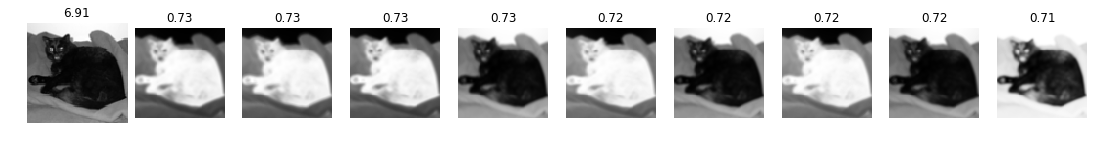

[6, 3, 2, 5, 4, 1, 7, 8, 0]
6


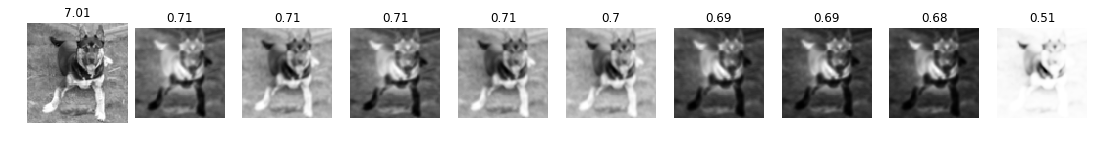

[3, 6, 5, 2, 4, 1, 7, 8, 0]
3


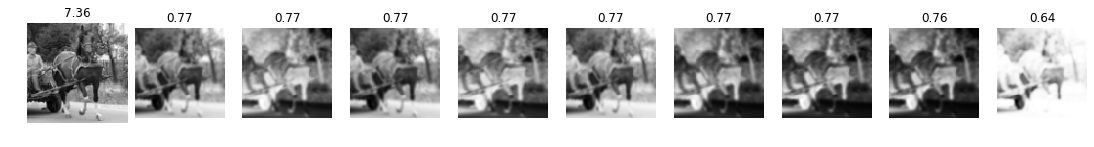

[8, 7, 1, 4, 3, 6, 2, 5, 0]
8


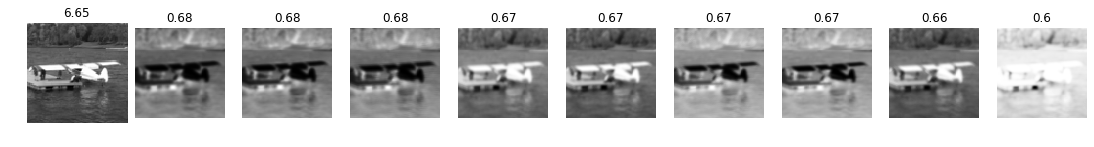

[4, 2, 1, 3, 5, 6, 7, 8, 0]
4


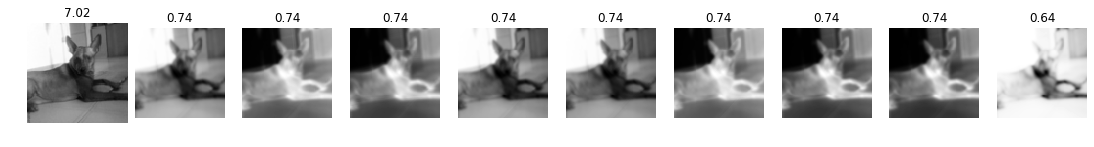

[6, 5, 2, 3, 4, 1, 7, 8, 0]
6


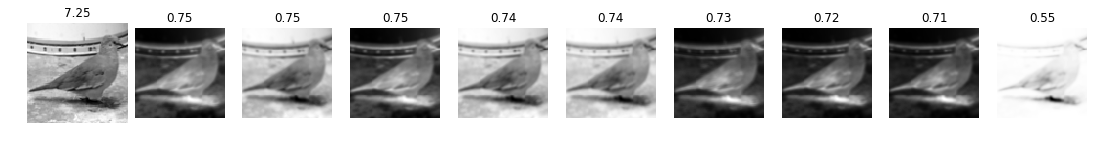

[4, 3, 6, 2, 5, 1, 7, 8, 0]
4


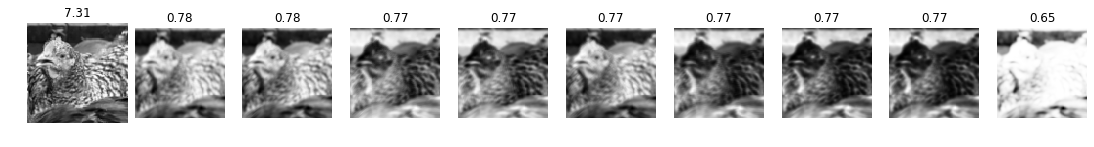

[4, 1, 2, 6, 7, 3, 5, 8, 0]
4


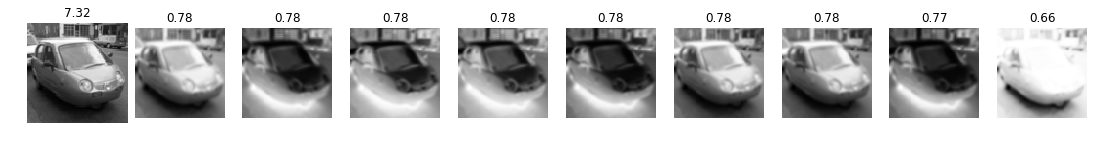

[6, 2, 5, 3, 4, 1, 7, 8, 0]
6


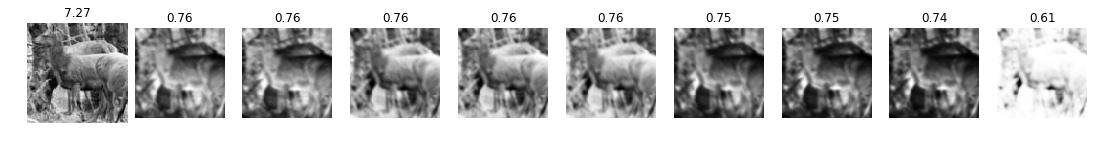

In [ ]:
# show images
for current_batch_index in range(0,len(train_images),batch_size):
    current_batch = train_images[current_batch_index:current_batch_index+batch_size]
    
    current_image_resize = np.asarray([resize(np.squeeze(x),(92,92)) for x in current_batch])[:,:,:,None]
    current_image_resize = (current_image_resize-current_image_resize.min((0,1,2),keepdims=True))/(current_image_resize.max((0,1,2),keepdims=True)-current_image_resize.min((0,1,2),keepdims=True)+1e-8)
    latent_feature = sess.run(layer2_e,feed_dict={x_encoding:current_batch})
    latent_feature = (latent_feature-latent_feature.min((0,1,2),keepdims=True))/(latent_feature.max((0,1,2),keepdims=True)-latent_feature.min((0,1,2),keepdims=True)+1e-8)

    for image_index in range(len(current_batch)-10):
        plt.figure(figsize=(2*num_of_aug+1,3))
        
        plt.subplot(1,num_of_aug,1)
        plt.imshow(np.squeeze(current_image_resize[image_index]),cmap='gray')
        upper_bound = calc_MI(current_image_resize[image_index].ravel(),current_image_resize[image_index].ravel())
        plt.title(str(np.around(upper_bound,2)))
        plt.axis('off')
        
        all_image_mi = []
        for image_index2 in range(len(latent_feature.T)): 
            all_image_mi.append(calc_MI(latent_feature[image_index,:,:,image_index2].ravel(),current_image_resize[image_index].ravel()))
        all_image_mi_sort = sorted(range(len(all_image_mi)), key=lambda k: all_image_mi[k])[::-1]
        best_indexn = all_image_mi_sort[0]
        print(all_image_mi_sort)
        print(best_indexn)
        count = 2
        for high_index in all_image_mi_sort:
            plt.subplot(1,num_of_aug+1,count)
            plt.imshow(np.squeeze(latent_feature[image_index,:,:,high_index]),cmap='gray'); plt.axis('off')
            current_mi= calc_MI(latent_feature[image_index,:,:,high_index].ravel(),current_image_resize[image_index].ravel())
            percent   = 1-(upper_bound-current_mi)/upper_bound
            plt.title(str(np.around(percent,2)))
            count = count + 1
        plt.show()
    train_images = shuffle(train_images)
    break
    break

In [ ]:
# train classifier
num_epoch = 20

# read the data
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)
test_images  = test_images.mean(3,keepdims=True)
test_images  = (test_images-test_images.min((0,1,2),keepdims=True))/(test_images.max((0,1,2),keepdims=True)-test_images.min((0,1,2),keepdims=True)+1e-8)

avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []
dividsion = 2
for iter in range(num_epoch):
    
    # train for training images
    for current_batch_index in range(0,len(train_images),batch_size//dividsion):
        current_batch = train_images[current_batch_index:current_batch_index+batch_size//dividsion]
        current_label = train_labels[current_batch_index:current_batch_index+batch_size//dividsion]
        latent_feature = sess.run(layer2_e,feed_dict={x_encoding:current_batch}) 
        latent_feature = (latent_feature-latent_feature.min((0,1,2),keepdims=True))/(latent_feature.max((0,1,2),keepdims=True)-latent_feature.min((0,1,2),keepdims=True)+1e-8)
        latent_feature = np.reshape(np.transpose(latent_feature,(0,3,1,2)),(batch_size//dividsion*num_of_aug,92,92))[:,:,:,None]
        latent_labels  = np.asarray([ [x]*num_of_aug for x in current_label]).reshape((batch_size//dividsion*num_of_aug,10))

        sess_results = sess.run([accuracy,class_train,extra_update_ops],feed_dict={x:latent_feature,y:latent_labels})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + 
                         ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + 
                         ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

    # test for training images
    for current_batch_index in range(0,len(test_images),batch_size):
        current_batch = test_images[current_batch_index:current_batch_index+batch_size]
        current_label = test_labels[current_batch_index:current_batch_index+batch_size]
        latent_feature = sess.run(layer2_e,feed_dict={x_encoding:current_batch})[:,:,:,2][:,:,:,None]
        latent_feature = (latent_feature-latent_feature.min((0,1,2),keepdims=True))/(latent_feature.max((0,1,2),keepdims=True)-latent_feature.min((0,1,2),keepdims=True)+1e-8)
        sess_results = sess.run([accuracy],feed_dict={x:latent_feature,y:current_label,is_training:False})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + 
                         ' batch : ' + str(current_batch_index) + '/'+ str(len(test_images)) + 
                         ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_test = avg_acc_test + sess_results[0] 
        
    # ======================== print reset ========================
    if iter%1 == 0 :
        train_images,train_labels = shuffle(train_images,train_labels)
        sys.stdout.write("Current : "+ str(iter) + "\t" +
              " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size*dividsion),3)) + "\t" +
              " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
        sys.stdout.flush();
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================

In [ ]:
# len(test_images)
from scipy import stats
accuray_test = 0
for current_batch_index in range(len(test_images)):
    current_batch = test_images[current_batch_index:current_batch_index+1]
    current_label = test_labels[current_batch_index:current_batch_index+1]
    latent_feature = sess.run(layer2_e,feed_dict={x_encoding:current_batch})
    latent_feature = np.transpose(latent_feature,(3,1,2,0))
    sess_results = sess.run(final_soft,feed_dict={x:latent_feature,y:current_label,is_training:False})
    m = stats.mode(np.argmax(sess_results,1))
    if m[0] == np.argmax(current_label,1):
        accuray_test = accuray_test + 1

print(accuray_test)
print(accuray_test/len(test_images))

In [ ]:
# train classifier (with sorting)
avg_acc_train = 0; avg_acc_test  = 0; train_acc = [];test_acc = []
num_epoch = 100

# read the data
train_images,train_labels,test_images,test_labels = read_STL10_data()
train_images = train_images.mean(3,keepdims=True)
train_images = (train_images-train_images.min((0,1,2),keepdims=True))/(train_images.max((0,1,2),keepdims=True)-train_images.min((0,1,2),keepdims=True)+1e-8)

for iter in range(num_epoch):
    
    for current_batch_index in range(0,len(train_images),batch_size):
        
        current_batch = train_images[current_batch_index:current_batch_index+batch_size]
        current_label = train_labels[current_batch_index:current_batch_index+batch_size]
        latent_feature = sess.run(layer2_e,feed_dict={x_encoding:current_batch}) 
        
#         current_image_resize = np.asarray([resize(np.squeeze(x),(90,90)) for x in current_batch])[:,:,:,None]
#         current_image_resize = (current_image_resize-current_image_resize.min((0,1,2),keepdims=True))/(current_image_resize.max((0,1,2),keepdims=True)-current_image_resize.min((0,1,2),keepdims=True)+1e-8)
#         current_aug_batch = []
#         for image_index in range(len(latent_feature)):
#             all_image_mi = []
#             for image_index2 in range(len(latent_feature.T)): 
#                 all_image_mi.append(calc_MI(latent_feature[image_index,:,:,image_index2].ravel(),current_image_resize[image_index].ravel()))
#             all_image_mi_sort = sorted(range(len(all_image_mi)), key=lambda k: all_image_mi[k])[::-1][:2]
#             current_aug_batch.append(latent_feature[image_index,:,:,all_image_mi_sort[0]])
#             current_aug_batch.append(latent_feature[image_index,:,:,all_image_mi_sort[1]])
#         current_aug_batch = np.asarray(current_aug_batch)[:,:,:,None]
#         current_aug_label = np.asarray([[x,x] for x in current_label ]).reshape((20,10))
        
        sess_results = sess.run([accuracy,class_train],feed_dict={x:latent_feature,y:current_label})
        sys.stdout.write(' Current Iter : ' + str(iter) + '/'+ str(num_epoch)  + 
                         ' batch : ' + str(current_batch_index) + '/'+ str(len(train_images)) + 
                         ' acc : ' + str(sess_results[0]) + '\r')
        sys.stdout.flush(); avg_acc_train = avg_acc_train + sess_results[0]

    # ======================== print reset ========================
    if iter%1 == 0 :
        sys.stdout.write("Current : "+ str(iter) + "\t" +
              " Train Acc : " + str(np.around(avg_acc_train/(len(train_images)/batch_size),3)) + "\t" +
              " Test Acc : "  + str(np.around(avg_acc_test/(len(test_images)/batch_size),3)) + "\t\n")
        sys.stdout.flush();
    avg_acc_train = 0 ; avg_acc_test  = 0
    # ======================== print reset ========================


In [ ]:
# prior  = tf.distributions.Uniform(low=tf.ones((92,92))*0.0,high=tf.ones((92,92))).sample(batch_size*num_of_aug)
prior  = tf.distributions.Normal(loc=tf.ones((92,92))*0.,scale=tf.ones((92,92))*10 ).sample(batch_size*num_of_aug)
prior  = tf.reshape(prior,(batch_size,92,92,num_of_aug)).eval()
# prior = (prior-prior.min((0,1,2),keepdims=True))/(prior.max((0,1,2),keepdims=True)-prior.min((0,1,2),keepdims=True)+1e-8)

for ii in range(10):
    plt.imshow(prior[ii,:,:,0],cmap='gray')
    plt.show()
    
print(prior[0,:,:,0])